In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact

In [2]:
from scipy.stats import ttest_ind
def t_test(x,y,alternative='both-sided'):
    _, double_p = ttest_ind(x,y,equal_var = False)
    if alternative == 'both-sided':
        pval = double_p
    elif alternative == 'greater':
        if np.mean(x) > np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    elif alternative == 'less':
        if np.mean(x) < np.mean(y):
            pval = double_p/2.
        else:
            pval = 1.0 - double_p/2.
    return pval

## Goal: Run statistical analysis for single cell data

Steps

1. read single cell data and only read in specific genes (columns) specified in external spreadsheet
    * FDA gene list
    * Novel gene list
2. apply statistical tests on a column by column basis for all genes for tumor vs ductal cells

    * chi sq test for counts of zeros
    * t test for raw data (sample means) - one tail = tumor > ductal
    * fisher exact test for count of zeros

## Outputs
    *tumor_ductal_statistical_testing_fda.csv
    *tumor_ductal_statistical_testing_novel.csv


### inputs

In [3]:
gene_list_csv = '../data/110920_fda drug list v1.csv'
gene_list_name = 'fda_v1'

In [4]:
rows = pd.read_csv('../data/rows for X.csv',header = None)

row_index = list(rows[0])

row_index = [val.lower() for val in row_index]

headers = pd.read_csv('../data/columns for X.csv', header = None)

genes_to_keep = pd.read_csv(gene_list_csv, header = None)

genes_to_keep = list(genes_to_keep[0])

column_names = list(headers[0])



In [5]:
df_raw = pd.read_csv('../data/X.csv',names = column_names, usecols=lambda c: c in set(genes_to_keep))

df_raw.shape

(88031, 125)

In [6]:
genes_to_keep = [gene for gene in genes_to_keep if gene in df_raw.columns]

Text(0.5, 1.0, 'percentage of 0s in columns - 153 subset of genes')

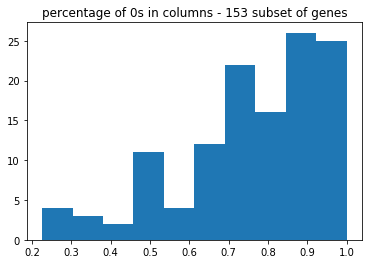

In [7]:
plt.hist((df_raw == 0).sum()/df_raw.shape[0])
plt.title('percentage of 0s in columns - 153 subset of genes')

In [8]:
df_raw.shape

(88031, 125)

In [9]:
df_raw.index = row_index
df_raw.reset_index(inplace=True)

In [10]:
df_raw = df_raw.rename({'index':'row_id'}, axis = 1)

In [11]:
df_raw.head()

,row_id,ATAD3B,PRKCZ,UBR4,SLC9A1,MACF1,EPS15,NRAS,NOTCH2,FCGR2A,...,TJP3,SLC27A1,LPAR2,PLAUR,CYTH2,PTPRH,PI4KA,MAPK1,MIF,BACE2
0,tumor,0.000000,0.0,0.0,0.0,3.036935,2.390654,0.0,0.0,0.0,...,0.0,0.0,0.0,3.426277,0.0,0.0,0.0,2.390654,0.0,2.390654
1,tumor,0.000000,0.0,0.0,0.0,3.188656,2.535909,0.0,0.0,0.0,...,0.0,0.0,0.0,2.535909,0.0,0.0,0.0,0.000000,0.0,0.000000
2,fibroblast,0.000000,0.0,0.0,0.0,0.000000,2.187330,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,tumor,2.274803,0.0,0.0,0.0,3.302408,2.274803,0.0,0.0,0.0,...,0.0,0.0,0.0,2.915173,0.0,0.0,0.0,0.000000,0.0,2.274803
4,endothelial,0.000000,0.0,0.0,0.0,2.431281,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


In [12]:
df_tumor_ductal = df_raw[(df_raw['row_id'] == 'tumor') | (df_raw['row_id'] == 'ductal')]

In [13]:
((df_tumor_ductal == 0).sum()/df_tumor_ductal.shape[0]).head()

row_id    0.000000
ATAD3B    0.847247
PRKCZ     0.805892
UBR4      0.686386
SLC9A1    0.854721
dtype: float64

In [14]:
gene_list = []
ttest_pvalue_list = []
chisq_pvalue_list = []
fisher_pvalue_list = []
more_counts_list = []
for gene in genes_to_keep:
    tumor_values = df_tumor_ductal[df_tumor_ductal['row_id'] == 'tumor'][gene]
    ductal_values = df_tumor_ductal[df_tumor_ductal['row_id'] == 'ductal'][gene]
    
    ttest_pvalue = t_test(tumor_values, ductal_values, alternative = 'greater')
    
    tumor_zero_count = np.sum(tumor_values ==0) 
    tumor_nonzero_count = np.sum(tumor_values !=0) 
    
    ductal_zero_count = np.sum(ductal_values ==0) 
    ductal_nonzero_count = np.sum(ductal_values !=0) 
    
    contingency = [[tumor_zero_count,ductal_zero_count],
              [tumor_nonzero_count,ductal_nonzero_count]]

    if (ductal_nonzero_count == 0) and (tumor_nonzero_count == 0):
    
        chisq_pvalue = 'n/a - all values are zero'
        fisher_pvalue = 'n/a - all values are zero'

    else:
        _, chisq_pvalue, _,_ = chi2_contingency(contingency)
        _, fisher_pvalue = fisher_exact(contingency)

    if tumor_nonzero_count/tumor_zero_count > ductal_nonzero_count/ductal_zero_count:
        more_counts_list.append('tumor')
    else:
        more_counts_list.append('ductal')
        
    gene_list.append(gene)
    ttest_pvalue_list.append(ttest_pvalue)
    chisq_pvalue_list.append(chisq_pvalue)
    fisher_pvalue_list.append(fisher_pvalue)

df_test_results = pd.DataFrame(
{
    'gene': gene_list,
    'ttest_pvalue': ttest_pvalue_list,
    'chisq_pvalue':chisq_pvalue_list,
    'fisher_pvalue':fisher_pvalue_list,
    'greater_pct_nonzero':more_counts_list
}
)

In [15]:
df_test_results.to_csv('outputs/tumor_ductal_statistical_testing_{}.csv'.format(gene_list_name),index=False)